Epoch 1, Loss: 1.4890, Train Acc: 0.3004
Epoch 2, Loss: 1.1799, Train Acc: 0.4843
Epoch 3, Loss: 0.9394, Train Acc: 0.6480
Epoch 4, Loss: 0.6803, Train Acc: 0.7601
Epoch 5, Loss: 0.4841, Train Acc: 0.8184
Epoch 6, Loss: 0.3830, Train Acc: 0.8430
Epoch 7, Loss: 0.3307, Train Acc: 0.8655
Epoch 8, Loss: 0.2726, Train Acc: 0.8969
Epoch 9, Loss: 0.2208, Train Acc: 0.9260
Epoch 10, Loss: 0.1495, Train Acc: 0.9507
Epoch 11, Loss: 0.1087, Train Acc: 0.9529
Epoch 12, Loss: 0.1014, Train Acc: 0.9619
Epoch 13, Loss: 0.1309, Train Acc: 0.9484
Epoch 14, Loss: 0.0803, Train Acc: 0.9776
Epoch 15, Loss: 0.0460, Train Acc: 0.9821
Epoch 16, Loss: 0.0199, Train Acc: 0.9955
Epoch 17, Loss: 0.0109, Train Acc: 0.9978
Epoch 18, Loss: 0.0047, Train Acc: 1.0000
Epoch 19, Loss: 0.0038, Train Acc: 1.0000
Epoch 20, Loss: 0.0022, Train Acc: 1.0000
Test Accuracy: 1.0000


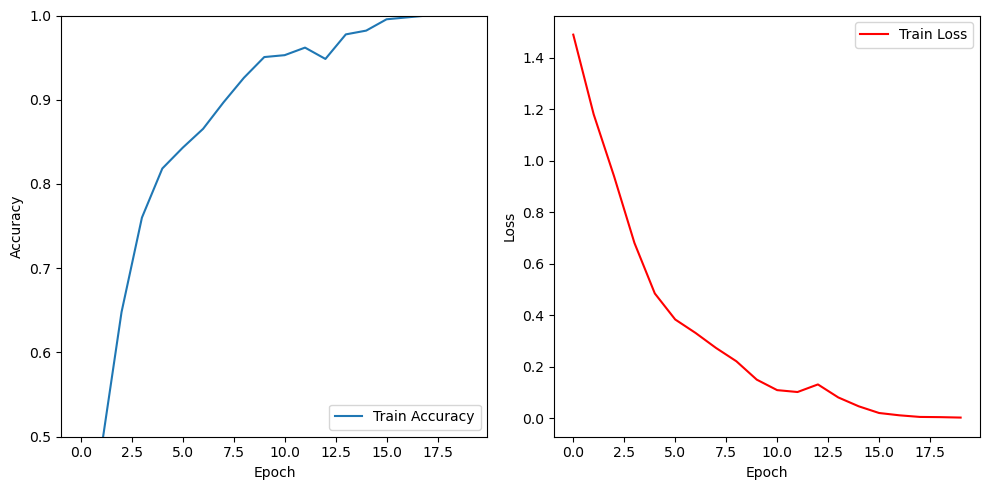

In [11]:

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  
        self.labels = []  
        self.classes = []  
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name) 
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.classes.index(label)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  
        self.fc2 = nn.Linear(64, num_classes)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN(num_classes=len(train_dataset.classes))  

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 20
train_acc = []
val_acc = []
train_loss = []  

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))  
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {correct/total:.4f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(10,5))


plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Epoch 1, Loss: 1.6229, Train Acc: 0.2377
Epoch 2, Loss: 1.6174, Train Acc: 0.2444
Epoch 3, Loss: 1.6119, Train Acc: 0.2646
Epoch 4, Loss: 1.6064, Train Acc: 0.2758
Epoch 5, Loss: 1.6012, Train Acc: 0.2892
Epoch 6, Loss: 1.5960, Train Acc: 0.3004
Epoch 7, Loss: 1.5909, Train Acc: 0.3229
Epoch 8, Loss: 1.5856, Train Acc: 0.3318
Epoch 9, Loss: 1.5803, Train Acc: 0.3296
Epoch 10, Loss: 1.5748, Train Acc: 0.3408
Epoch 11, Loss: 1.5690, Train Acc: 0.3453
Epoch 12, Loss: 1.5631, Train Acc: 0.4372
Epoch 13, Loss: 1.5568, Train Acc: 0.5067
Epoch 14, Loss: 1.5501, Train Acc: 0.5269
Epoch 15, Loss: 1.5429, Train Acc: 0.4484
Epoch 16, Loss: 1.5350, Train Acc: 0.3969
Epoch 17, Loss: 1.5264, Train Acc: 0.3677
Epoch 18, Loss: 1.5170, Train Acc: 0.3430
Epoch 19, Loss: 1.5066, Train Acc: 0.3296
Epoch 20, Loss: 1.4951, Train Acc: 0.3274
Test Accuracy: 0.3274


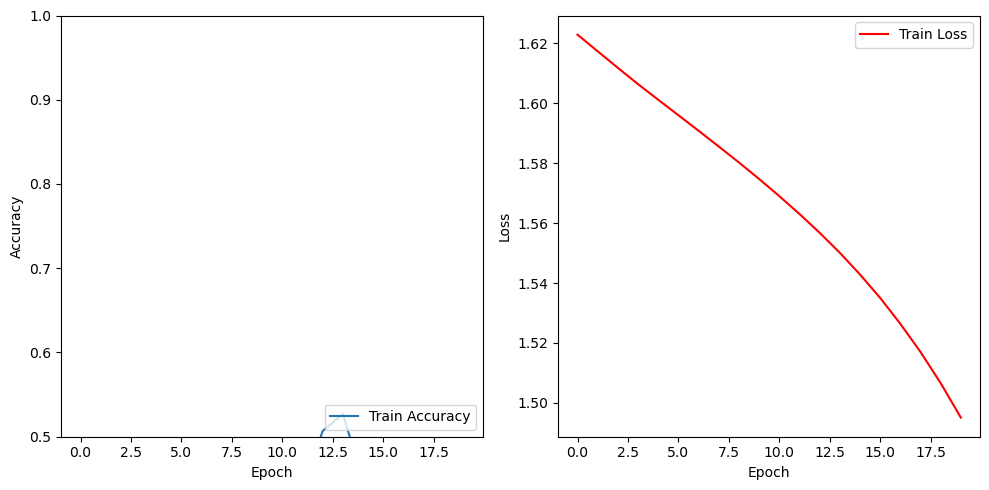

In [13]:

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  
        self.labels = []  
        self.classes = []  
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name) 
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.classes.index(label)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  
        self.fc2 = nn.Linear(64, num_classes)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN(num_classes=len(train_dataset.classes))  

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 20
train_acc = []
val_acc = []
train_loss = []  

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))  
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {correct/total:.4f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(10,5))


plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Epoch 1, Loss: 42.5016, Train Acc: 0.2534
Epoch 2, Loss: 1.3805, Train Acc: 0.3274
Epoch 3, Loss: 1.3487, Train Acc: 0.3139
Epoch 4, Loss: 1.1844, Train Acc: 0.3430
Epoch 5, Loss: 1.1364, Train Acc: 0.4058
Epoch 6, Loss: 1.1035, Train Acc: 0.5247
Epoch 7, Loss: 1.0325, Train Acc: 0.5583
Epoch 8, Loss: 1.1345, Train Acc: 0.5628
Epoch 9, Loss: 0.9323, Train Acc: 0.6457
Epoch 10, Loss: 0.8092, Train Acc: 0.7466
Epoch 11, Loss: 0.8964, Train Acc: 0.6659
Epoch 12, Loss: 0.8102, Train Acc: 0.6951
Epoch 13, Loss: 0.7429, Train Acc: 0.6726
Epoch 14, Loss: 0.6478, Train Acc: 0.7220
Epoch 15, Loss: 0.6856, Train Acc: 0.7265
Epoch 16, Loss: 0.5225, Train Acc: 0.7892
Epoch 17, Loss: 0.4516, Train Acc: 0.8296
Epoch 18, Loss: 0.9317, Train Acc: 0.6525
Epoch 19, Loss: 0.4692, Train Acc: 0.8341
Epoch 20, Loss: 0.4315, Train Acc: 0.8318
Test Accuracy: 0.7892


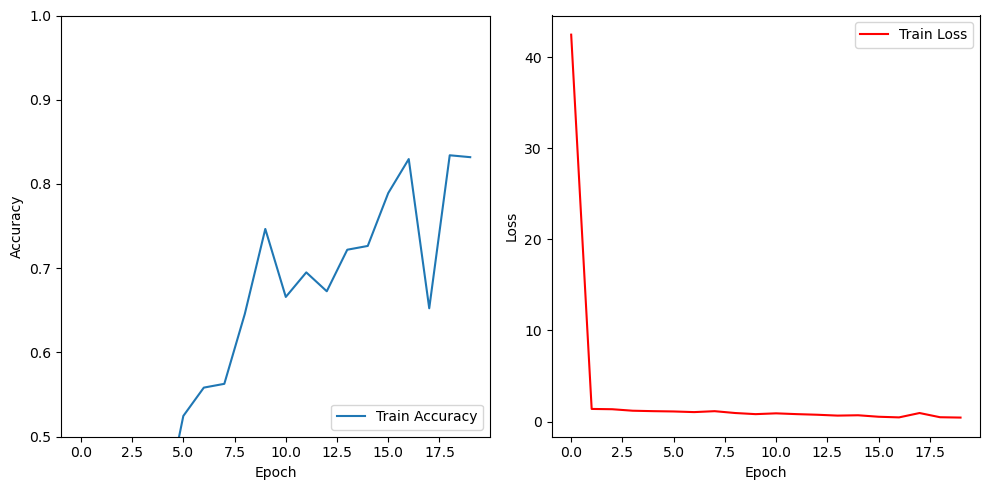

In [9]:

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  
        self.labels = []  
        self.classes = []  
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name) 
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.classes.index(label)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  
        self.fc2 = nn.Linear(64, num_classes)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN(num_classes=len(train_dataset.classes))  

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 20
train_acc = []
val_acc = []
train_loss = []  

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))  
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {correct/total:.4f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(10,5))


plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 1/20, Loss: 1.4011, Train Acc: 0.4753
Epoch 2/20, Loss: 1.0006, Train Acc: 0.6121
Epoch 3/20, Loss: 0.7411, Train Acc: 0.6928
Epoch 4/20, Loss: 0.5700, Train Acc: 0.7758
Epoch 5/20, Loss: 0.4178, Train Acc: 0.8363
Epoch 6/20, Loss: 0.3238, Train Acc: 0.8812
Epoch 7/20, Loss: 0.2764, Train Acc: 0.8946
Epoch 8/20, Loss: 0.1852, Train Acc: 0.9260
Epoch 9/20, Loss: 0.1402, Train Acc: 0.9619
Epoch 10/20, Loss: 0.1073, Train Acc: 0.9574
Epoch 11/20, Loss: 0.0699, Train Acc: 0.9753
Epoch 12/20, Loss: 0.0420, Train Acc: 0.9843
Epoch 13/20, Loss: 0.0242, Train Acc: 0.9955
Epoch 14/20, Loss: 0.0183, Train Acc: 0.9910
Epoch 15/20, Loss: 0.0134, Train Acc: 0.9978
Epoch 16/20, Loss: 0.0152, Train Acc: 0.9933
Epoch 17/20, Loss: 0.0191, Train Acc: 0.9955
Epoch 18/20, Loss: 0.0254, Train Acc: 0.9933
Epoch 19/20, Loss: 0.0166, Train Acc: 0.9933
Epoch 20/20, Loss: 0.0245, Train Acc: 0.9888
Test Accuracy: 0.9888


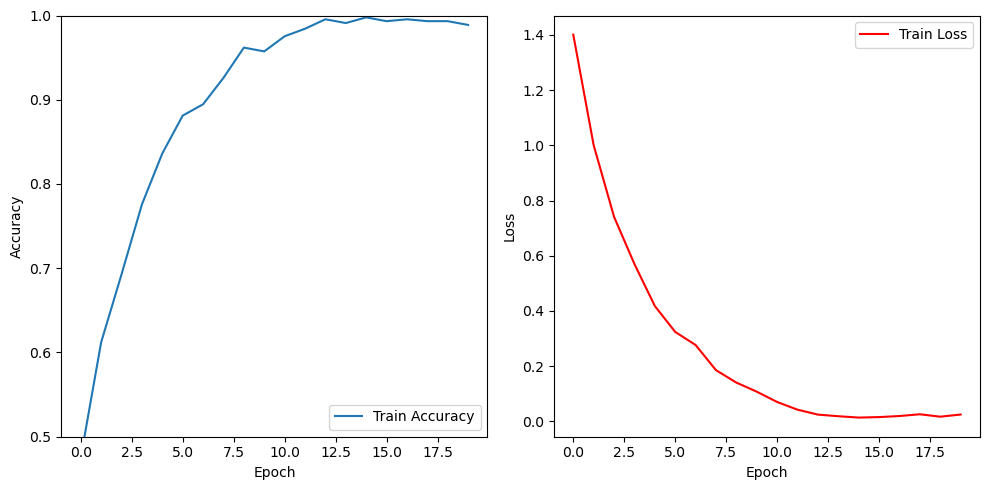

In [2]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name)
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.classes.index(label)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  
        return x


model = CNN(num_classes=len(train_dataset.classes))

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.005)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 20
train_acc = []
train_loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  
        _, predicted = torch.max(probabilities, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Epoch 1/20, Loss: 1.6151, Train Acc: 0.0269
Epoch 2/20, Loss: 1.6088, Train Acc: 0.3004
Epoch 3/20, Loss: 1.6026, Train Acc: 0.3274
Epoch 4/20, Loss: 1.5961, Train Acc: 0.3274
Epoch 5/20, Loss: 1.5894, Train Acc: 0.3274
Epoch 6/20, Loss: 1.5824, Train Acc: 0.3274
Epoch 7/20, Loss: 1.5753, Train Acc: 0.3274
Epoch 8/20, Loss: 1.5679, Train Acc: 0.3274
Epoch 9/20, Loss: 1.5601, Train Acc: 0.3274
Epoch 10/20, Loss: 1.5520, Train Acc: 0.3274
Epoch 11/20, Loss: 1.5434, Train Acc: 0.3274
Epoch 12/20, Loss: 1.5341, Train Acc: 0.3274
Epoch 13/20, Loss: 1.5242, Train Acc: 0.3274
Epoch 14/20, Loss: 1.5137, Train Acc: 0.3274
Epoch 15/20, Loss: 1.5027, Train Acc: 0.3274
Epoch 16/20, Loss: 1.4912, Train Acc: 0.3274
Epoch 17/20, Loss: 1.4793, Train Acc: 0.3274
Epoch 18/20, Loss: 1.4669, Train Acc: 0.3274
Epoch 19/20, Loss: 1.4543, Train Acc: 0.3274
Epoch 20/20, Loss: 1.4423, Train Acc: 0.3274
Test Accuracy: 0.3274


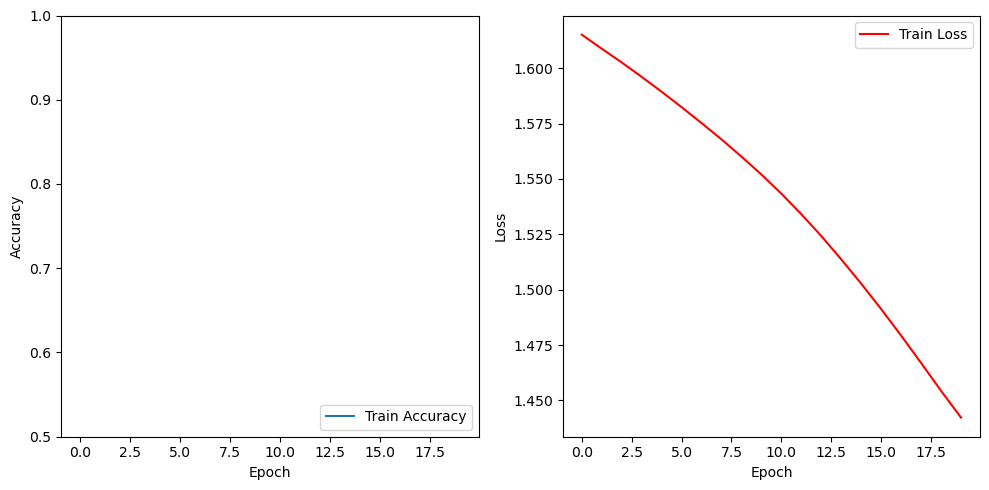

In [4]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name)
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.classes.index(label)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  
        return x


model = CNN(num_classes=len(train_dataset.classes))

criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(), lr=0.005)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 20
train_acc = []
train_loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  
        _, predicted = torch.max(probabilities, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Epoch 1/20, Loss: 22.8822, Train Acc: 0.2108
Epoch 2/20, Loss: 1.2006, Train Acc: 0.4103
Epoch 3/20, Loss: 0.9970, Train Acc: 0.4955
Epoch 4/20, Loss: 0.9494, Train Acc: 0.5807
Epoch 5/20, Loss: 0.7028, Train Acc: 0.7309
Epoch 6/20, Loss: 0.7513, Train Acc: 0.7108
Epoch 7/20, Loss: 0.4852, Train Acc: 0.8139
Epoch 8/20, Loss: 0.7295, Train Acc: 0.7399
Epoch 9/20, Loss: 0.4431, Train Acc: 0.8341
Epoch 10/20, Loss: 0.3595, Train Acc: 0.8655
Epoch 11/20, Loss: 0.4178, Train Acc: 0.8520
Epoch 12/20, Loss: 0.2916, Train Acc: 0.9126
Epoch 13/20, Loss: 0.3736, Train Acc: 0.8924
Epoch 14/20, Loss: 0.3169, Train Acc: 0.8857
Epoch 15/20, Loss: 0.1851, Train Acc: 0.9283
Epoch 16/20, Loss: 0.1502, Train Acc: 0.9417
Epoch 17/20, Loss: 0.2061, Train Acc: 0.9395
Epoch 18/20, Loss: 0.2153, Train Acc: 0.9238
Epoch 19/20, Loss: 0.0922, Train Acc: 0.9709
Epoch 20/20, Loss: 0.0748, Train Acc: 0.9731
Test Accuracy: 0.9888


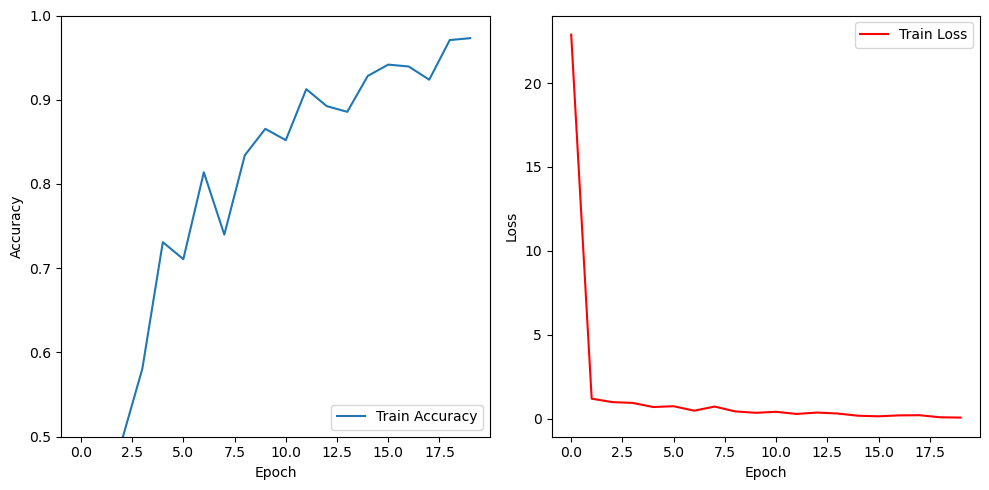

In [6]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name)
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.classes.index(label)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Softmax қоспаймыз
        return x


model = CNN(num_classes=len(train_dataset.classes))

criterion = nn.CrossEntropyLoss() 
optimizer = optim.RMSprop(model.parameters(), lr=0.005)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 20
train_acc = []
train_loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  
        _, predicted = torch.max(probabilities, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
